### **MobileNetV2**
* **Model**
  * MobileNetV2 from: https://github.com/chenhang98/mobileNet-v2_cifar10/blob/master
* **Best accuracy** : [Test set] Average loss: 0.0040, Accuracy: 8735/10000 (87.35%)
* **FLOPS** : 319,015,424


* **hyperparameter**
  * lr=0.1
  * weight_decay=4e-5
  * batch size = 100
  * momentum = 0.9
  * epoch = 25
  * training time : 3439.5674

* **optimizer**
  * SGD

* **Data augmentation**
  *   
          transforms.Pad(4),
          transforms.RandomHorizontalFlip(),
          transforms.RandomCrop(32),
          transforms.ToTensor()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_path = "/content/drive/MyDrive/ML Project/MobileNetV2/model"

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Current GPU Index:", torch.cuda.current_device())
    print("Current GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Current GPU Index: 0
Current GPU Name: Tesla T4


In [ ]:
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                 train=True,
                                 transform=transform,
                                 download=True)

test_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                train=False,
                                transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:04<00:00, 42014643.37it/s]


Extracting ./cifar_10data/cifar-10-python.tar.gz to ./cifar_10data/


In [ ]:
import math

class BaseBlock(nn.Module):
    alpha = 1

    def __init__(self, input_channel, output_channel, t = 6, downsample = False):
        """
            t:  expansion factor, t*input_channel is channel of expansion layer
            alpha:  width multiplier, to get thinner models
            rho:    resolution multiplier, to get reduced representation
        """
        super(BaseBlock, self).__init__()
        self.stride = 2 if downsample else 1
        self.downsample = downsample
        self.shortcut = (not downsample) and (input_channel == output_channel)

        # apply alpha
        input_channel = int(self.alpha * input_channel)
        output_channel = int(self.alpha * output_channel)

        # for main path:
        c  = t * input_channel
        # 1x1   point wise conv
        self.conv1 = nn.Conv2d(input_channel, c, kernel_size = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(c)
        # 3x3   depth wise conv
        self.conv2 = nn.Conv2d(c, c, kernel_size = 3, stride = self.stride, padding = 1, groups = c, bias = False)
        self.bn2 = nn.BatchNorm2d(c)
        # 1x1   point wise conv
        self.conv3 = nn.Conv2d(c, output_channel, kernel_size = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channel)


    def forward(self, inputs):
        # main path
        x = F.relu6(self.bn1(self.conv1(inputs)), inplace = True)
        x = F.relu6(self.bn2(self.conv2(x)), inplace = True)
        x = self.bn3(self.conv3(x))

        # shortcut path
        x = x + inputs if self.shortcut else x

        return x

class MobileNetV2(nn.Module):
    def __init__(self, output_size, alpha = 1):
        super(MobileNetV2, self).__init__()
        self.output_size = output_size

        # first conv layer
        self.conv0 = nn.Conv2d(3, int(32*alpha), kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn0 = nn.BatchNorm2d(int(32*alpha))

        # build bottlenecks
        BaseBlock.alpha = alpha
        self.bottlenecks = nn.Sequential(
            BaseBlock(32, 16, t = 1, downsample = False),
            BaseBlock(16, 24, downsample = False),
            BaseBlock(24, 24),
            BaseBlock(24, 32, downsample = False),
            BaseBlock(32, 32),
            BaseBlock(32, 32),
            BaseBlock(32, 64, downsample = True),
            BaseBlock(64, 64),
            BaseBlock(64, 64),
            BaseBlock(64, 64),
            BaseBlock(64, 96, downsample = False),
            BaseBlock(96, 96),
            BaseBlock(96, 96),
            BaseBlock(96, 160, downsample = True),
            BaseBlock(160, 160),
            BaseBlock(160, 160),
            BaseBlock(160, 320, downsample = False))

        # last conv layers and fc layer
        self.conv1 = nn.Conv2d(int(320*alpha), 1280, kernel_size = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(1280)
        self.fc = nn.Linear(1280, output_size)

        # weights init
        self.weights_init()


    def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))

            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def forward(self, inputs):

        # first conv layer
        x = F.relu6(self.bn0(self.conv0(inputs)), inplace = True)
        # assert x.shape[1:] == torch.Size([32, 32, 32])

        # bottlenecks
        x = self.bottlenecks(x)
        # assert x.shape[1:] == torch.Size([320, 8, 8])

        # last conv layer
        x = F.relu6(self.bn1(self.conv1(x)), inplace = True)
        # assert x.shape[1:] == torch.Size([1280,8,8])

        # global pooling and fc (in place of conv 1x1 in paper)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)

        return x

In [ ]:
from torchsummary import summary

model = MobileNetV2(10, alpha = 1).to(device)

print("MobileNetV2 torchsummary")
summary(model, (3, 32, 32))

MobileNetV2 torchsummary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           1,024
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]             288
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 16, 32, 32]             512
       BatchNorm2d-8           [-1, 16, 32, 32]              32
         BaseBlock-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 96, 32, 32]           1,536
      BatchNorm2d-11           [-1, 96, 32, 32]             192
           Conv2d-12           [-1, 96, 32, 32]             864
      BatchNorm2d-13           [-1, 96, 32, 32]             192
           Con

In [ ]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=7ae51109bfb41dd357a0c93b90bd0d73ce85d5616de3acc37632e77179ca7a53
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=a5088bf3cb01834664ea9dc652cc1ba9f9000f5cfcd8292c47c2e551106fd997
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [ ]:
from fvcore.nn import FlopCountAnalysis

inputs = torch.randn(1, 3, 32, 32).to(device)

flops = FlopCountAnalysis(model, inputs)
print(flops.total())  # 총 FLOPS 출력

319015424


In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1, weight_decay = 4e-5, momentum = 0.9)

In [ ]:
from tqdm import tqdm
import torch
import os

model.train()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

best_accuracy = 0.0
accuracy_list = []
test_loss_list = []
train_loss_list = []

import time
start = time.time()


for epoch in range(25):
    print(f"{epoch}th epoch starting.")
    batch_num = len(train_loader)

    train_loss_epoch, test_loss, correct, total = 0, 0, 0, 0


    pbar = tqdm(enumerate(train_loader), total=batch_num, dynamic_ncols=True, position=0, leave=True)
    for i, (images, labels) in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        train_loss = loss_function(model(images), labels)
        train_loss.backward()

        optimizer.step()
        train_loss_epoch += train_loss.item()

        # 현재 배치의 Loss 값 표시
        pbar.set_description(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {train_loss.item():.4f}")

    train_loss_list.append(train_loss_epoch / batch_num)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            test_loss += loss_function(output, labels).item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()

            total += labels.size(0)

    accuracy = 100. * correct / total
    test_loss_list.append(test_loss / batch_num)
    accuracy_list.append(accuracy)

    # 최고 성능 모델 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        model_filename = f"best_model_epoch_{epoch+1}.pkt"
        model_save_path = os.path.join(save_path, model_filename)

        torch.save(model.state_dict(), model_save_path)
        # print(f"Epoch {epoch + 1}: Best model saved with accuracy: {accuracy:.4f}")

end = time.time()
print("Time elapsed in training is: {}".format(end - start))

0th epoch starting.


Epoch 1, Batch 500, Loss: 0.6833: 100%|██████████| 500/500 [02:09<00:00,  3.87it/s]


1th epoch starting.


Epoch 2, Batch 500, Loss: 0.6235: 100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


2th epoch starting.


Epoch 3, Batch 500, Loss: 0.5327: 100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


3th epoch starting.


Epoch 4, Batch 500, Loss: 0.6964: 100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


4th epoch starting.


Epoch 5, Batch 500, Loss: 0.5760: 100%|██████████| 500/500 [02:09<00:00,  3.85it/s]


5th epoch starting.


Epoch 6, Batch 500, Loss: 0.3473: 100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


6th epoch starting.


Epoch 7, Batch 500, Loss: 0.4383: 100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


7th epoch starting.


Epoch 8, Batch 500, Loss: 0.5628: 100%|██████████| 500/500 [02:14<00:00,  3.71it/s]


8th epoch starting.


Epoch 9, Batch 500, Loss: 0.2947: 100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


9th epoch starting.


Epoch 10, Batch 500, Loss: 0.3070: 100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


10th epoch starting.


Epoch 11, Batch 500, Loss: 0.4127: 100%|██████████| 500/500 [02:08<00:00,  3.89it/s]


11th epoch starting.


Epoch 12, Batch 500, Loss: 0.3240: 100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


12th epoch starting.


Epoch 13, Batch 500, Loss: 0.4166: 100%|██████████| 500/500 [02:13<00:00,  3.76it/s]


13th epoch starting.


Epoch 14, Batch 500, Loss: 0.2908: 100%|██████████| 500/500 [02:09<00:00,  3.85it/s]


14th epoch starting.


Epoch 15, Batch 500, Loss: 0.2312: 100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


15th epoch starting.


Epoch 16, Batch 500, Loss: 0.1362: 100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


16th epoch starting.


Epoch 17, Batch 500, Loss: 0.1938: 100%|██████████| 500/500 [02:11<00:00,  3.80it/s]


17th epoch starting.


Epoch 18, Batch 500, Loss: 0.1897: 100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


18th epoch starting.


Epoch 19, Batch 500, Loss: 0.2487: 100%|██████████| 500/500 [02:09<00:00,  3.87it/s]


19th epoch starting.


Epoch 20, Batch 500, Loss: 0.1415: 100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


20th epoch starting.


Epoch 21, Batch 500, Loss: 0.3649: 100%|██████████| 500/500 [02:08<00:00,  3.89it/s]


21th epoch starting.


Epoch 22, Batch 500, Loss: 0.2110: 100%|██████████| 500/500 [02:08<00:00,  3.89it/s]


22th epoch starting.


Epoch 23, Batch 500, Loss: 0.1503: 100%|██████████| 500/500 [02:08<00:00,  3.89it/s]


23th epoch starting.


Epoch 24, Batch 500, Loss: 0.1949: 100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


24th epoch starting.


Epoch 25, Batch 500, Loss: 0.2097: 100%|██████████| 500/500 [02:08<00:00,  3.89it/s]


Time elapsed in training is: 3439.5674891471863


In [ ]:
import pandas as pd

df = pd.DataFrame({
    'Accuracy': accuracy_list,
    'Test Loss': test_loss_list,
    'Train Loss' : train_loss_list
})

df.to_csv('/content/drive/MyDrive/ML Project/MobileNetV2/metrics.csv', index=False)

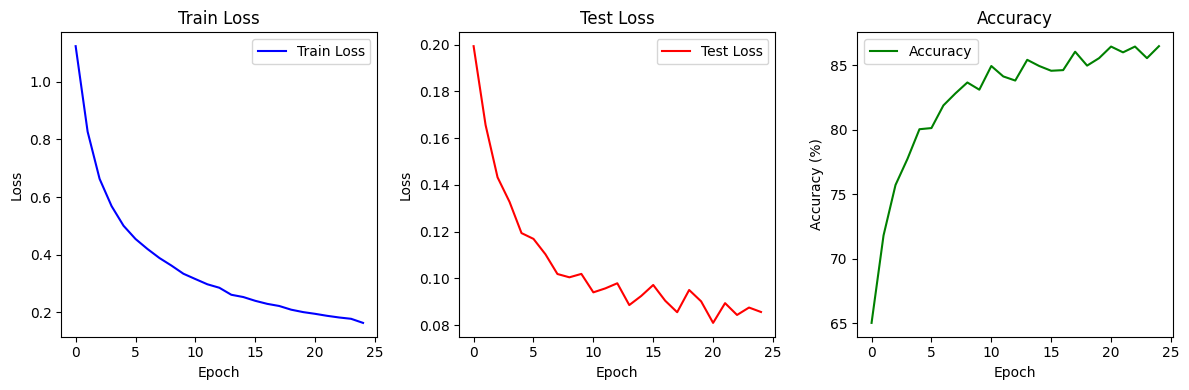

In [ ]:
import matplotlib.pyplot as plt

# 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/ML Project/MobileNetV2/metrics.csv')

# 그래프 크기 설정
plt.figure(figsize=(12, 4))

# Train Loss
plt.subplot(1, 3, 1)
plt.plot(df['Train Loss'], label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()

# Test Loss
plt.subplot(1, 3, 2)
plt.plot(df['Test Loss'], label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()

# Accuracy
plt.subplot(1, 3, 3)
plt.plot(df['Accuracy'], label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model = MobileNetV2(10, alpha = 1).to(device)

# 저장된 Best 가중치 불러오기
model_path = '/content/drive/MyDrive/ML Project/MobileNetV2/model/best_model_epoch_25.pkt'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
model.eval()
test_loss, correct, total = 0, 0, 0

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)
with torch.no_grad():  #using context manager
    for images, labels in test_loader :
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        test_loss += loss_function(output, labels).item()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()

        total += labels.size(0)

print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /total, correct, total,
        100. * correct / total))

[Test set] Average loss: 0.0040, Accuracy: 8735/10000 (87.35%)



In [ ]:
# Best 가중치 상위 폴더 저장
import shutil

source_path = '/content/drive/MyDrive/ML Project/MobileNetV2/model/best_model_epoch_25.pkt'
destination_path = '/content/drive/MyDrive/ML Project/MobileNetV2'

shutil.move(source_path, destination_path)

'/content/drive/MyDrive/ML Project/MobileNetV2/best_model_epoch_25.pkt'